In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import plotly.express as px 
import plotly.graph_objects as go  


data = pd.read_csv('dynamic_pricing.csv')
data.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


## Exploratory Data Analysis

In [3]:
data.describe()

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,60.372000,27.076000,50.031000,4.257220,99.58800,372.502623
std,23.701506,19.068346,29.313774,0.435781,49.16545,187.158756
min,20.000000,5.000000,0.000000,3.500000,10.00000,25.993449
25%,40.000000,11.000000,25.000000,3.870000,59.75000,221.365202
50%,60.000000,22.000000,51.000000,4.270000,102.00000,362.019426
75%,81.000000,38.000000,75.000000,4.632500,143.00000,510.497504
max,100.000000,89.000000,100.000000,5.000000,180.00000,836.116419


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


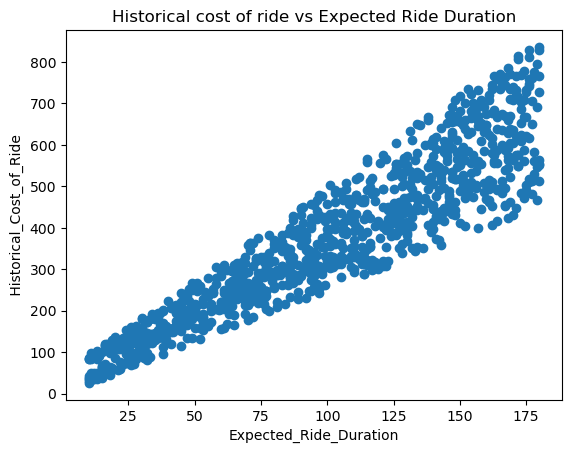

In [5]:
# Relationship between expected ride duration and historical cost of the ride
plt.scatter(x= data['Expected_Ride_Duration'], y=data['Historical_Cost_of_Ride'])
plt.xlabel('Expected_Ride_Duration')
plt.ylabel(' Historical_Cost_of_Ride ')
plt.title('Historical cost of ride vs Expected Ride Duration')
plt.show()

In [6]:
correlation = data['Expected_Ride_Duration'].corr(data['Historical_Cost_of_Ride'])
correlation

0.9275471833882493

From our visualization, we can notice that the longer the duration the higher the price. This can be backed with the strong correlation between the two of about 0.928

In [7]:
fig = px.box(data, x= 'Vehicle_Type', y='Historical_Cost_of_Ride', 
title='Historical cost of ride ve Vehicle Type')
fig.show()

We can see that there is a slight higher price charged for the premium vehicles compared to the economy vehicles. This can be seen with the higher maximum value(836) compared to that of economy(794)

## Implenting a Dynamic Pricing Strategy

According to the EDA, we have seen the company uses a pricing model that mainly considers the expected ride duration as a factor to determine the price for a ride. 
Now we going to implement a dynamic pricing strategy aiming to adjust the ride costs dynamically based on the demand and supply levels observed in the data. it will capture high-demand periods and low-supply scenarios to increase prices, while low-demand periods and high-supply situations will lead to price reductions. 


In [8]:
import numpy as np 

# Calculate the demand_multiplier based on percentile for high and low demand
high_demand_percentile = 75
low_demand_percentile = 25
data['demand_multiplier'] = np.where(
    data['Number_of_Riders'] > np.percentile(data['Number_of_Riders'], high_demand_percentile),
    data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], high_demand_percentile),
    data['Number_of_Riders'] / np.percentile(data['Number_of_Riders'], low_demand_percentile)
)

# Calculate supply_multiplier based on percentile for high and low demand 
high_supply_percentile = 75
low_supply_percentile = 25

data['supply_multiplier'] = np.where(
    data['Number_of_Drivers'] > np.percentile(data['Number_of_Drivers'], low_supply_percentile),
    np.percentile(data['Number_of_Drivers'], high_supply_percentile) / data['Number_of_Drivers'],
    np.percentile(data['Number_of_Drivers'], low_supply_percentile) / data['Number_of_Drivers']
)

# Define price adjustment factors for high and low demand/supply
demand_threshold_high = 1.2 # Higher demand threshold
demand_threshold_low = 0.8 # Lower demand threshold
supply_threshold_high = 0.8 # Higher supply threshold
supply_threshold_low = 1.2 # Lower supply threshold

# Calculate adjsuted_ride_cost for dynamic pricing 
data['adjusted_ride_cost'] = data['Historical_Cost_of_Ride'] * (
    np.maximum(data['demand_multiplier'], demand_threshold_low) * 
    np.maximum(data['supply_multiplier'], supply_threshold_high)
)

In [9]:
# Calculate the profit percentage for each ride
data['profit_percentage'] = ((data['adjusted_ride_cost'] - data['Historical_Cost_of_Ride'])/ data['Historical_Cost_of_Ride']) * 100

# Identify profitable rides where profit percentage is positive
profitable_rides = data[data['profit_percentage'] > 0]

 # Identify loss rides where profit percentage is negative
loss_rides = data[data['profit_percentage'] < 0]


In [10]:
data.head(10)

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride,demand_multiplier,supply_multiplier,adjusted_ride_cost,profit_percentage
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273,1.111111,0.844444,266.710528,-6.172840
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753,1.450000,0.974359,245.653817,41.282051
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469,1.050000,1.225806,424.478684,28.709677
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232,1.098765,1.357143,701.155452,49.118166
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422,1.950000,1.727273,1952.472427,236.818182
5,59,35,Urban,Silver,83,3.51,Night,Economy,128,339.955361,1.475000,1.085714,544.414227,60.142857
6,93,43,Suburban,Regular,44,4.41,Afternoon,Premium,16,104.061541,1.148148,0.883721,105.585268,1.464255
7,62,39,Rural,Gold,83,3.59,Afternoon,Premium,47,235.811864,1.550000,0.974359,356.136379,51.025641
8,79,14,Rural,Silver,71,3.74,Evening,Economy,128,501.412517,1.975000,2.714286,2687.929246,436.071429
9,42,6,Rural,Silver,21,3.85,Night,Premium,128,398.993365,1.050000,1.833333,768.062227,92.500000


In [11]:
import plotly.graph_objects as go
# Calculate the count of profitable and loss rides
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

# Create a donut chart to show the distribution 
labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

fig = go.Figure(data =[go.Pie(labels = labels, values=values, hole=0.4)])
fig.update_layout(title = 'Profitability of Rides(Dynamic Pricing vs. Historical Pricing)')
fig.show()

Now lets look at the relationship between the expected ride duration and the cost of the ride based on the dynamic pricing strategy 

In [12]:
fig = px.scatter(data, 
                 x= 'Expected_Ride_Duration', 
                 y= 'adjusted_ride_cost', 
                 title = 'Expected Ride Duration vs. Cost of the ride',
                 trendline= 'ols')
fig.show()

## Training a Predictive Model 
Now as we have implemeted a dynamic pricing strategy, let's train a Machine Learning model. Before training lets process the data

In [13]:
from sklearn.preprocessing import StandardScaler
import numpy as np 

In [14]:
def data_preprocessing_pipeline(data):
    # Identify numeric and categorical features 
    numeric_features = data.select_dtypes(include=['float','int']).columns
    categorical_features = data.select_dtypes(include=['object']).columns

    #Handle missing values in numeric features
    data[numeric_features] = data[numeric_features].fillna(data[numeric_features].mean())

    # Detect and handle outliers in numeric features using IQR
    for feature in numeric_features:
        Q1 = data[feature].quartile(0.25)
        Q3 = data[feature].quartile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)
        data[feature] = np.where((data[feature ] < lower_bound) | (data[feature] > upper_bound),
                                 data[feature].mean(), data[feature]) 

    # Handle missing values in categorical features
    data[categorical_features] = data[categorical_features].fillna(data[categorical_features].mode().iloc[0])

    return data


With Vehicle type as a valuable factor, lets convert it into numerical feature before moving forward 

In [16]:
data['Vehicle_Type'] = data['Vehicle_Type'].map({'Premium': 1, 'Economy': 0})

Split the data and train the Machine Learning model to predict the cost of a ride 

In [17]:
# splitting data
from sklearn.model_selection import train_test_split

x= np.array(data[['Number_of_Riders', 'Number_of_Drivers', 'Vehicle_Type', 'Expected_Ride_Duration' ]])
y= np.array(data[['adjusted_ride_cost']])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# Reshape y to 1D array 
y_train = y_train.ravel()
y_test = y_test.ravel()

#Training a random forest regression model 
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

In [20]:
# Testing the model using some input values

def get_vehicle_type_numeric(vehicle_type):
    vehicle_type_mapping = {'Premium': 1, 'Economy': 0}
    vehicle_type_numeric = vehicle_type_mapping.get(vehicle_type)
    return vehicle_type_numeric

# Predicting using user input values 
def predict_price(Number_of_Riders, Number_of_Drivers, vehicle_type, Expected_Ride_Duration):
    vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
    if vehicle_type_numeric is None:
        raise ValueError('Invalid vehicle type')
    input_data = np.array([[Number_of_Riders, Number_of_Drivers, vehicle_type_numeric, Expected_Ride_Duration]])
    predict_price = model.predict(input_data)
    return predict_price


# Expected prediction using user input value 
user_number_of_riders = 50
user_number_of_drivers = 25
user_vehicle_type = 'Economy'
Expected_Ride_Duration = 30
predicted_price = predict_price(user_number_of_riders, user_number_of_drivers, user_vehicle_type, Expected_Ride_Duration)

print('Predicted price:', predicted_price)

Predicted price: [268.51488046]


In [23]:
# A comparison of the actual and predicted results 

# Predict on the test set 
y_pred = model.predict(x_test)

# Create a scatter plot with actual ve predicted values 
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = y_test.flatten(),
    y = y_pred, 
    mode='markers',
    name = 'Actual vs Predicted'
))

# Add a line representing the ideal case 
fig.add_trace(go.Scatter(
    x=[min(y_test.flatten()), max(y_test.flatten())],
    y=[min(y_test.flatten()), max(y_test.flatten())],
    mode = 'lines', 
    name = 'Ideal',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title='Actual vs Predicted Values', 
    xaxis_title = 'Actual Values',
    yaxis_title='Predicted Values',
    showlegend = True
)

fig.show()